In [106]:
import os
from dotenv import load_dotenv

import pandas as pd
from sqlalchemy import create_engine, text
import panel as pn
import matplotlib.pyplot as plt


pn.extension('tabulator', notifications=True)
load_dotenv()

BokehModel(combine_events=True, render_bundle={'docs_json': {'8d0c9952-df0e-466d-95b2-ddbb3e458d0f': {'version…

True

In [107]:
DB_HOST = os.getenv("DB_HOST")
DB_NAME = os.getenv("DB_NAME")
DB_USER = os.getenv("DB_USER")
DB_PASS = os.getenv("DB_PASS")

engine = create_engine(
    f"postgresql+psycopg2://{DB_USER}:{DB_PASS}@{DB_HOST}/{DB_NAME}"
)

In [108]:
id_visita = pn.widgets.IntInput(name="ID da Visita")

data = pn.widgets.DatePicker(name="Data da Visita")

localizacao = pn.widgets.TextInput(
    name="Local da Visita",
    placeholder="Ex: Centro Histórico de Fortaleza"
)

horario_entrada = pn.widgets.TextInput(
    name="Horário de Entrada", placeholder="HH:MM"
)

horario_saida = pn.widgets.TextInput(
    name="Horário de Saída", placeholder="HH:MM"
)

num_visitantes = pn.widgets.IntInput(
    name="Número de Visitantes", start=1
)


In [109]:
filtro_data = pn.widgets.DatePicker(
    name="Filtrar por data"
)

filtro_min_visitantes = pn.widgets.IntInput(
    name="Mínimo de visitantes",
    start=0,
    value=0
)

btn_filtrar = pn.widgets.Button(
    name="Aplicar filtro",
    button_type="success"
)

btn_limpar = pn.widgets.Button(
    name="Limpar filtro",
    button_type="default"
)



In [110]:
def carregar_visitas():
    query = """
        SELECT *
        FROM visita_cultural
        WHERE 1=1
    """
    params = {}

    if filtro_data.value:
        query += " AND data_ = :data"
        params["data"] = filtro_data.value

    if filtro_min_visitantes.value > 0:
        query += " AND num_visitantes >= :num"
        params["num"] = filtro_min_visitantes.value

    query += " ORDER BY data_"

    return pd.read_sql(text(query), engine, params=params)
None


In [111]:
tabela = pn.widgets.Tabulator(
    carregar_visitas(),
    pagination='remote',
    page_size=5
)

In [112]:
def atualizar_tabela():
    tabela.value = carregar_visitas()


In [113]:
def criar_visita(event):
    query = text("""
        INSERT INTO visita_cultural
        (id_visita, horario_entrada, horario_saida, data_, num_visitantes, localizacao)
        VALUES (:id, :he, :hs, :data, :num, :loc)
    """)
    try:
        with engine.begin() as conn:
            conn.execute(query, {
                "id": id_visita.value,
                "he": horario_entrada.value,
                "hs": horario_saida.value,
                "data": data.value,
                "num": num_visitantes.value,
                "loc": localizacao.value
            })

        pn.state.notifications.success("Visita cadastrada!")
        atualizar_tabela()

    except Exception as e:
        pn.state.notifications.error(str(e))
    None



In [114]:
def atualizar_visita(event):
    query = text("""
        UPDATE visita_cultural
        SET horario_entrada = :he,
            horario_saida = :hs,
            data_ = :data,
            num_visitantes = :num,
            localizacao = :loc
        WHERE id_visita = :id
    """)
    try:
        with engine.begin() as conn:
            conn.execute(query, {
                "id": id_visita.value,
                "he": horario_entrada.value,
                "hs": horario_saida.value,
                "data": data.value,
                "num": num_visitantes.value,
                "loc": localizacao.value
            })

        pn.state.notifications.success("Visita atualizada!")
        atualizar_tabela()

    except Exception as e:
        pn.state.notifications.error(str(e))
    None


In [115]:
def deletar_visita(event):
    try:
        with engine.begin() as conn:
            conn.execute(
                text("DELETE FROM visita_cultural WHERE id_visita = ?"),
                {"id": id_visita.value}
            )

        pn.state.notifications.success("Visita removida!")
        atualizar_tabela()

    except Exception as e:
        pn.state.notifications.error(str(e))
    None


In [116]:
def aplicar_filtro(event):
    atualizar_tabela()


def limpar_filtro(event):
    filtro_data.value = None
    filtro_min_visitantes.value = 0
    atualizar_tabela()

In [117]:
btn_criar = pn.widgets.Button(
    name="Cadastrar Visita",
    button_type="primary"
)
btn_criar.on_click(criar_visita)

btn_update = pn.widgets.Button(
    name="Atualizar Visita",
    button_type="warning"
)
btn_update.on_click(atualizar_visita)

btn_delete = pn.widgets.Button(
    name="Excluir Visita",
    button_type="danger"
)
btn_delete.on_click(deletar_visita)

btn_filtrar.on_click(aplicar_filtro)
btn_limpar.on_click(limpar_filtro)


Watcher(inst=Button(name='Limpar filtro'), cls=<class 'panel.widgets.button.Button'>, fn=<function limpar_filtro at 0x00000193BBE08360>, mode='args', onlychanged=False, parameter_names=('clicks',), what='value', queued=False, precedence=0)

In [118]:
app = pn.Column(
    "# Visita Cultural",

    "## Cadastrar/ Editar / Excluir",
    id_visita,
    data,
    localizacao,
    horario_entrada,
    horario_saida,
    num_visitantes,
    pn.Row(btn_criar, btn_update, btn_delete),

    "## Filtrar visitas por data",
    filtro_data,
    filtro_min_visitantes,
    pn.Row(btn_filtrar, btn_limpar),

    "## Visitas cadastradas",
    tabela,
    
)

app.servable()

BokehModel(combine_events=True, render_bundle={'docs_json': {'54fb159c-79bf-43e0-a13c-529c241a290a': {'version…

In [119]:
query = """
    SELECT
    COALESCE(p.nome_atribuido, vc.localizacao) AS local,
    SUM(vc.num_visitantes) AS total_pessoas
    FROM visita_cultural vc
    LEFT JOIN patrimonio p
        ON vc.localizacao = p.nome_atribuido
    GROUP BY local
    ORDER BY total_pessoas DESC;
"""
df = pd.read_sql(text(query), engine)
df


,local,total_pessoas
0,Asilo São Cornélio: prédio (Casa à Rua do Cate...,60
1,"Casa na Ladeira do Morro do Valongo, 21",45
2,Hospital da Santa Casa de Misericórdia: prédio,40
3,Museu da União dos Caixeiros Viajantes: acervo,35
4,Igreja de Nossa Senhora da Conceição dos Milit...,32
5,Capela dos Noviços da Ordem Terceira de São Fr...,27
6,Igreja Matriz de São Pedro e Capela da Ordem T...,25
7,Mosteiro e Igreja de São Bento,22
8,Convento e Igreja de Santo Antônio,18
9,Igreja de Nossa Senhora dos Prazeres,7


C:\Users\grazi\AppData\Local\Temp\ipykernel_6252\1885080626.py:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


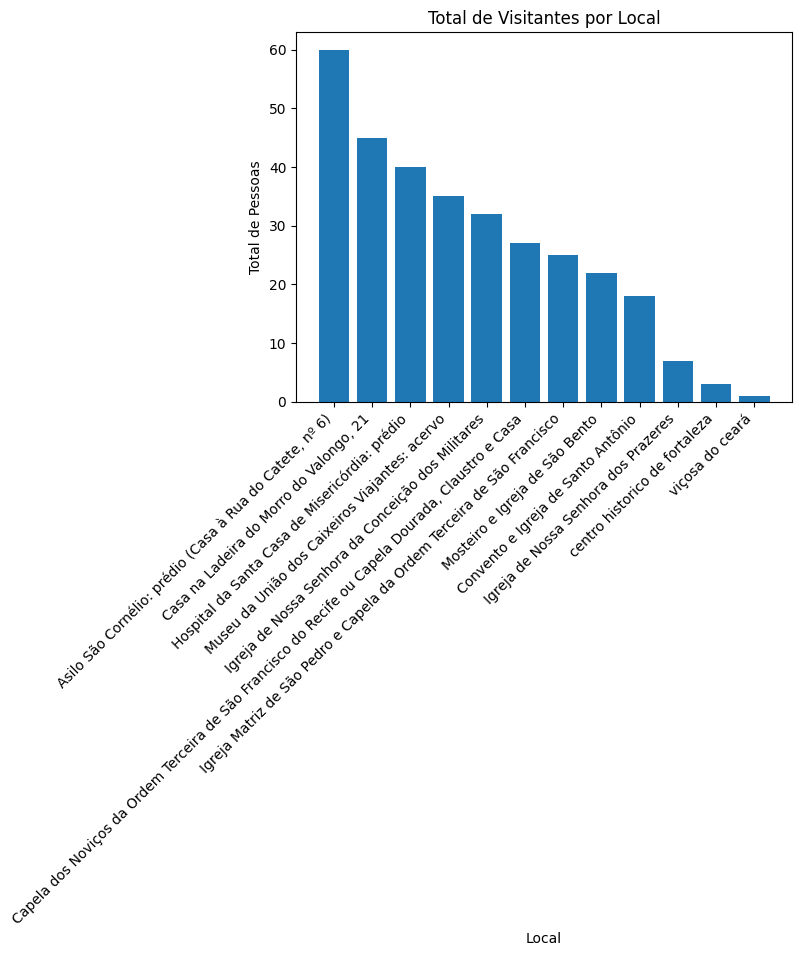

In [120]:
df = df.sort_values(by="total_pessoas", ascending=False)

plt.figure()
plt.bar(df["local"], df["total_pessoas"])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Local")
plt.ylabel("Total de Pessoas")
plt.title("Total de Visitantes por Local")
plt.tight_layout()
plt.show()